In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bearing-data/B021_2.mat
/kaggle/input/bearing-data/B028_3.mat
/kaggle/input/bearing-data/IR007_3.mat
/kaggle/input/bearing-data/IR014_3.mat
/kaggle/input/bearing-data/OR00712_2.mat
/kaggle/input/bearing-data/IR028_2.mat
/kaggle/input/bearing-data/B014_3.mat
/kaggle/input/bearing-data/IR014_0.mat
/kaggle/input/bearing-data/IR007_2.mat
/kaggle/input/bearing-data/OR0073_1.mat
/kaggle/input/bearing-data/Normal_3.mat
/kaggle/input/bearing-data/IR028_0.mat
/kaggle/input/bearing-data/B021_1.mat
/kaggle/input/bearing-data/B028_1.mat
/kaggle/input/bearing-data/IR014_1.mat
/kaggle/input/bearing-data/Normal_1.mat
/kaggle/input/bearing-data/OR0076_1.mat
/kaggle/input/bearing-data/B007_1.mat
/kaggle/input/bearing-data/B014_0.mat
/kaggle/input/bearing-data/OR0146_2.mat
/kaggle/input/bearing-data/B014_1.mat
/kaggle/input/bearing-data/OR0216_3.mat
/kaggle/input/bearing-data/B028_0.mat
/kaggle/input/bearing-data/OR02112_2.mat
/kaggle/input/bearing-data/B007_3.mat
/kaggle/input/bearing-dat

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import spectrogram
from scipy.stats import kurtosis, skew
from tqdm import tqdm
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [29]:
sampling_rate = 12000
window_sec = 5
out_shape = (128, 128)
data_path = "/kaggle/input/bearing-data"  


def classify_file(filename):
    if "IR" in filename:
        return 1  
    elif "B0" in filename:
        return 3  
    elif "OR" in filename:
        return 2  
    elif "Normal" in filename or "" in filename:
        return 0  
    else:
        return -1  

In [30]:
def segment_signal(signal, fs=12000, window_sec=5):
    win_len = fs * window_sec
    segments = []
    for start in range(0, len(signal), win_len):
        chunk = signal[start:start+win_len]
        if len(chunk) == win_len:
            segments.append(chunk)
    return segments

def segment_to_spectrogram(segment, fs=12000, out_shape=(128, 128)):
    f, t, Sxx = spectrogram(segment, fs, nperseg=256, noverlap=128)
    Sxx_db = 10 * np.log10(Sxx + 1e-8)
    out = np.zeros(out_shape)
    h, w = min(Sxx_db.shape[0], out_shape[0]), min(Sxx_db.shape[1], out_shape[1])
    out[:h, :w] = Sxx_db[:h, :w]
    return out

In [31]:
X, y = [], []
mat_files = glob.glob(os.path.join(data_path, "*.mat"))

for filepath in tqdm(mat_files):
    try:
        fname = os.path.basename(filepath)
        label = classify_file(fname)
        if label == -1:
            continue  # skip unknown types

        data = loadmat(filepath)
        key = [k for k in data.keys() if "DE_time" in k][0]  # auto-detect key
        signal = data[key].ravel()

        segments = segment_signal(signal, fs=sampling_rate, window_sec=window_sec)
        for seg in segments:
            spec = segment_to_spectrogram(seg, fs=sampling_rate, out_shape=out_shape)
            X.append(spec)
            y.append(label)

    except Exception as e:
        print(f"Error processing {filepath}: {e}")


X = np.array(X)
y = np.array(y)
X = X[..., np.newaxis]  


print("Final dataset:")
print("Total samples:", X.shape[0])
print("Shape of each image:", X.shape[1:])
print("Label distribution:", pd.Series(y).value_counts().sort_index().to_dict())

100%|██████████| 64/64 [00:00<00:00, 145.20it/s]

Final dataset:
Total samples: 148
Shape of each image: (128, 128, 1)
Label distribution: {0: 28, 1: 32, 2: 56, 3: 32}


In [32]:

X, y = [], []
mat_files = glob.glob(os.path.join(data_path, "*.mat"))

for filepath in tqdm(mat_files):
    try:
        fname = os.path.basename(filepath)
        label = classify_file(fname)
        if label == -1:
            continue  # skip unknown types

        data = loadmat(filepath)
        key = [k for k in data.keys() if "DE_time" in k][0]  # auto-detect key
        signal = data[key].ravel()

        segments = segment_signal(signal, fs=sampling_rate, window_sec=window_sec)
        for seg in segments:
            # Original
            spec = segment_to_spectrogram(seg, fs=sampling_rate, out_shape=out_shape)
            X.append(spec)
            y.append(label)

            # Augmentation 1: Add Gaussian noise
            noisy = seg + np.random.normal(0, 0.01, size=seg.shape)
            noisy_spec = segment_to_spectrogram(noisy, fs=sampling_rate, out_shape=out_shape)
            X.append(noisy_spec)
            y.append(label)

            # Augmentation 2: Time shift (roll)
            shifted = np.roll(seg, 200)
            shifted_spec = segment_to_spectrogram(shifted, fs=sampling_rate, out_shape=out_shape)
            X.append(shifted_spec)
            y.append(label)

    except Exception as e:
        print(f"Error processing {filepath}: {e}")


X = np.array(X)
y = np.array(y)
X = X[..., np.newaxis]  

# Summary
print("Final dataset:")
print("Total samples:", X.shape[0])
print("Shape of each image:", X.shape[1:])
print("Label distribution:", pd.Series(y).value_counts().sort_index().to_dict())


100%|██████████| 64/64 [00:01<00:00, 46.68it/s]

Final dataset:
Total samples: 444
Shape of each image: (128, 128, 1)
Label distribution: {0: 84, 1: 96, 2: 168, 3: 96}


In [33]:
# --- Cross-Validation Block with Improvements ---
print("\n--- 5-Fold Cross Validation ---")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
    print(f"Fold {fold}")
    unique, counts = np.unique(y[test_idx], return_counts=True)
    print("Test set label distribution:", dict(zip(unique, counts)))

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(128, 128, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X[train_idx], y[train_idx], epochs=10, verbose=0)
    y_pred = model.predict(X[test_idx]).argmax(axis=1)
    acc = accuracy_score(y[test_idx], y_pred)
    print(f"Accuracy: {acc:.4f}\n")
    accuracies.append(acc)

print("Cross-validation accuracies:", [round(a, 4) for a in accuracies])
print("Average accuracy:", round(np.mean(accuracies), 4))


--- 5-Fold Cross Validation ---
Fold 1
Test set label distribution: {0: 17, 1: 19, 2: 33, 3: 20}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Accuracy: 1.0000

Fold 2
Test set label distribution: {0: 17, 1: 20, 2: 33, 3: 19}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Accuracy: 0.3708

Fold 3
Test set label distribution: {0: 17, 1: 19, 2: 34, 3: 19}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Accuracy: 0.9888

Fold 4
Test set label distribution: {0: 17, 1: 19, 2: 34, 3: 19}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Accuracy: 1.0000

Fold 5
Test set label distribution: {0: 16, 1: 19, 2: 34, 3: 19}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Accuracy: 0.9886

Cross-validation accuracies: [1.0, 0.3708, 0.9888, 1.0, 0.9886]
Average accuracy: 0.8696


In [1]:
# Enhanced Bearing Health Classification Model
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from scipy.signal import spectrogram, stft, welch
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'sampling_rate': 12000,
    'window_sec': 5,
    'spectrogram_shape': (224, 224),  # Changed for EfficientNet compatibility
    'n_folds': 5,
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'early_stopping_patience': 10,
    'data_path': "/kaggle/input/bearing-data"
}

class BearingDataProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
    
    def classify_file(self, filename):
        """Enhanced file classification with more robust pattern matching"""
        filename_upper = filename.upper()
        if "IR" in filename_upper:
            return 1  # Inner Race
        elif "B0" in filename_upper or "BALL" in filename_upper:
            return 3  # Ball
        elif "OR" in filename_upper:
            return 2  # Outer Race
        elif "NORMAL" in filename_upper or filename_upper.endswith('.MAT'):
            return 0  # Normal
        else:
            return -1
    
    def extract_statistical_features(self, signal):
        """Extract time-domain statistical features"""
        return np.array([
            np.mean(signal),
            np.std(signal),
            np.var(signal),
            skew(signal),
            kurtosis(signal),
            np.max(signal),
            np.min(signal),
            np.median(signal),
            np.percentile(signal, 25),
            np.percentile(signal, 75),
            np.sqrt(np.mean(signal**2)),  # RMS
            np.max(np.abs(signal)),  # Peak
            np.sqrt(np.mean(signal**2)) / np.mean(np.abs(signal))  # Crest factor
        ])
    
    def extract_frequency_features(self, signal, fs):
        """Extract frequency-domain features"""
        freqs, psd = welch(signal, fs, nperseg=1024)
        
        # Frequency bands
        low_freq = psd[(freqs >= 0) & (freqs < 1000)].sum()
        mid_freq = psd[(freqs >= 1000) & (freqs < 3000)].sum()
        high_freq = psd[(freqs >= 3000) & (freqs < 6000)].sum()
        
        return np.array([
            low_freq,
            mid_freq,
            high_freq,
            np.argmax(psd),  # Dominant frequency
            np.sum(psd),     # Total power
            np.mean(psd),    # Mean power
            np.std(psd)      # Power std
        ])
    
    def segment_signal(self, signal, fs, window_sec, overlap=0.5):
        """Segment signal with overlap for better data utilization"""
        win_len = int(fs * window_sec)
        step = int(win_len * (1 - overlap))
        segments = []
        
        for start in range(0, len(signal) - win_len + 1, step):
            segments.append(signal[start:start + win_len])
        
        return segments
    
    def create_enhanced_spectrogram(self, segment, fs, out_shape):
        """Create enhanced spectrogram with better resolution"""
        # STFT with higher resolution
        f, t, Zxx = stft(segment, fs, nperseg=512, noverlap=256)
        Sxx = np.abs(Zxx) ** 2
        
        # Convert to dB scale
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Normalize
        Sxx_db = (Sxx_db - np.mean(Sxx_db)) / (np.std(Sxx_db) + 1e-8)
        
        # Resize to target shape
        from scipy import ndimage
        Sxx_resized = ndimage.zoom(Sxx_db, 
                                  (out_shape[0]/Sxx_db.shape[0], 
                                   out_shape[1]/Sxx_db.shape[1]))
        
        return Sxx_resized
    
    def augment_signal(self, signal):
        """Advanced signal augmentation techniques"""
        augmented = []
        
        # Original
        augmented.append(signal)
        
        # Gaussian noise
        noise_std = np.std(signal) * 0.05
        noisy = signal + np.random.normal(0, noise_std, signal.shape)
        augmented.append(noisy)
        
        # Time shifting
        shift = np.random.randint(-len(signal)//10, len(signal)//10)
        shifted = np.roll(signal, shift)
        augmented.append(shifted)
        
        # Amplitude scaling
        scale = np.random.uniform(0.8, 1.2)
        scaled = signal * scale
        augmented.append(scaled)
        
        # Time stretching (simple decimation/interpolation)
        if np.random.random() > 0.5:
            # Compress
            indices = np.linspace(0, len(signal)-1, int(len(signal)*0.9)).astype(int)
            compressed = signal[indices]
            # Pad to original length
            padded = np.pad(compressed, (0, len(signal)-len(compressed)), 'edge')
            augmented.append(padded)
        
        return augmented
    
    def process_data(self, apply_augmentation=True):
        """Process all data files with enhanced features"""
        X_spectrograms = []
        X_features = []
        y = []
        
        mat_files = glob.glob(os.path.join(self.config['data_path'], "*.mat"))
        print(f"Found {len(mat_files)} files to process")
        
        for filepath in tqdm(mat_files, desc="Processing files"):
            try:
                fname = os.path.basename(filepath)
                label = self.classify_file(fname)
                if label == -1:
                    continue
                
                # Load data
                data = loadmat(filepath)
                key = [k for k in data.keys() if "DE_time" in k or "de_time" in k.lower()][0]
                signal = data[key].ravel()
                
                # Segment signal
                segments = self.segment_signal(
                    signal, 
                    self.config['sampling_rate'], 
                    self.config['window_sec']
                )
                
                for segment in segments:
                    # Apply augmentation if enabled
                    if apply_augmentation and label != 0:  # Don't over-augment normal data
                        augmented_segments = self.augment_signal(segment)
                    else:
                        augmented_segments = [segment]
                    
                    for aug_segment in augmented_segments:
                        # Create spectrogram
                        spectrogram_data = self.create_enhanced_spectrogram(
                            aug_segment, 
                            self.config['sampling_rate'], 
                            self.config['spectrogram_shape']
                        )
                        
                        # Extract traditional features
                        stat_features = self.extract_statistical_features(aug_segment)
                        freq_features = self.extract_frequency_features(
                            aug_segment, 
                            self.config['sampling_rate']
                        )
                        combined_features = np.concatenate([stat_features, freq_features])
                        
                        X_spectrograms.append(spectrogram_data)
                        X_features.append(combined_features)
                        y.append(label)
                        
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
        
        X_spectrograms = np.array(X_spectrograms)
        X_features = np.array(X_features)
        y = np.array(y)
        
        # Add channel dimension for spectrograms
        if len(X_spectrograms.shape) == 3:
            X_spectrograms = X_spectrograms[..., np.newaxis]
        
        # Convert to RGB for EfficientNet
        X_spectrograms = np.repeat(X_spectrograms, 3, axis=-1)
        
        # Normalize features
        X_features = self.scaler.fit_transform(X_features)
        
        return X_spectrograms, X_features, y

class EnhancedBearingClassifier:
    def __init__(self, config):
        self.config = config
        self.model = None
    
    def create_hybrid_model(self, spectrogram_shape, feature_shape, num_classes=4):
        """Create a hybrid model combining CNN and traditional ML features"""
        
        # Spectrogram branch (EfficientNet-based)
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=spectrogram_shape
        )
        
        # Fine-tune the last few layers
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        spectrogram_input = layers.Input(shape=spectrogram_shape, name='spectrogram_input')
        x = base_model(spectrogram_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)
        spectrogram_features = layers.Dense(128, activation='relu')(x)
        
        # Traditional features branch
        feature_input = layers.Input(shape=(feature_shape,), name='feature_input')
        y = layers.Dense(64, activation='relu')(feature_input)
        y = layers.Dropout(0.2)(y)
        y = layers.Dense(32, activation='relu')(y)
        
        # Combine branches
        combined = layers.concatenate([spectrogram_features, y])
        combined = layers.Dense(64, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        output = layers.Dense(num_classes, activation='softmax', name='output')(combined)
        
        model = Model(inputs=[spectrogram_input, feature_input], outputs=output)
        
        # Compile with advanced optimizer
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=self.config['learning_rate'],
            weight_decay=0.01
        )
        
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        return model
    
    def create_callbacks(self):
        """Create training callbacks"""
        return [
            callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=self.config['early_stopping_patience'],
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            ),
            callbacks.ModelCheckpoint(
                'best_model.h5',
                monitor='val_accuracy',
                save_best_only=True
            )
        ]
    
    def train_and_evaluate(self, X_spec, X_feat, y):
        """Train and evaluate using cross-validation"""
        kf = StratifiedKFold(n_splits=self.config['n_folds'], shuffle=True, random_state=42)
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_spec, y), 1):
            print(f"\n=== Fold {fold} ===")
            
            # Split data
            X_spec_train, X_spec_val = X_spec[train_idx], X_spec[val_idx]
            X_feat_train, X_feat_val = X_feat[train_idx], X_feat[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Create model
            self.model = self.create_hybrid_model(
                X_spec.shape[1:], 
                X_feat.shape[1]
            )
            
            # Train
            history = self.model.fit(
                [X_spec_train, X_feat_train], y_train,
                validation_data=([X_spec_val, X_feat_val], y_val),
                epochs=self.config['epochs'],
                batch_size=self.config['batch_size'],
                callbacks=self.create_callbacks(),
                verbose=1
            )
            
            # Evaluate
            y_pred = self.model.predict([X_spec_val, X_feat_val]).argmax(axis=1)
            accuracy = accuracy_score(y_val, y_pred)
            cv_scores.append(accuracy)
            
            print(f"Fold {fold} Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_val, y_pred, 
                                      target_names=['Normal', 'Inner Race', 'Outer Race', 'Ball']))
        
        print(f"\n=== Cross-Validation Results ===")
        print(f"CV Scores: {[round(score, 4) for score in cv_scores]}")
        print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
        
        return cv_scores
    
    def plot_training_history(self, history):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Accuracy
        axes[0, 0].plot(history.history['accuracy'], label='Training')
        axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        
        # Loss
        axes[0, 1].plot(history.history['loss'], label='Training')
        axes[0, 1].plot(history.history['val_loss'], label='Validation')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        
        # Precision
        axes[1, 0].plot(history.history['precision'], label='Training')
        axes[1, 0].plot(history.history['val_precision'], label='Validation')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        
        # Recall
        axes[1, 1].plot(history.history['recall'], label='Training')
        axes[1, 1].plot(history.history['val_recall'], label='Validation')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()

# Main execution
def main():
    # Initialize processor and classifier
    processor = BearingDataProcessor(CONFIG)
    classifier = EnhancedBearingClassifier(CONFIG)
    
    print("Processing bearing data...")
    X_spectrograms, X_features, y = processor.process_data(apply_augmentation=True)
    
    print(f"\nDataset Summary:")
    print(f"Total samples: {len(y)}")
    print(f"Spectrogram shape: {X_spectrograms.shape}")
    print(f"Feature shape: {X_features.shape}")
    print(f"Label distribution: {pd.Series(y).value_counts().sort_index().to_dict()}")
    
    # Train and evaluate
    print("\nStarting cross-validation training...")
    cv_scores = classifier.train_and_evaluate(X_spectrograms, X_features, y)
    
    return X_spectrograms, X_features, y, cv_scores

# Run the enhanced model
if __name__ == "__main__":
    X_spectrograms, X_features, y, cv_scores = main()

2025-06-10 19:25:27.952277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749583528.178353      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749583528.239757      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processing bearing data...
Found 64 files to process


Processing files: 100%|██████████| 64/64 [00:19<00:00,  3.29it/s]



Dataset Summary:
Total samples: 1044
Spectrogram shape: (1044, 224, 224, 3)
Feature shape: (1044, 20)
Label distribution: {1: 221, 2: 606, 3: 217}

Starting cross-validation training...

=== Fold 1 ===


I0000 00:00:1749583561.805993      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


I0000 00:00:1749583587.089343      96 service.cc:148] XLA service 0x7e6430114e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749583587.090239      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,32] vs. [1,128]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_20906[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_21715]

In [2]:
# Enhanced Bearing Health Classification Model
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from scipy.signal import spectrogram, stft, welch
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'sampling_rate': 12000,
    'window_sec': 5,
    'spectrogram_shape': (224, 224),  # Changed for EfficientNet compatibility
    'n_folds': 5,
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'early_stopping_patience': 10,
    'data_path': "/kaggle/input/bearing-data"
}

class BearingDataProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
    
    def classify_file(self, filename):
        """Enhanced file classification with more robust pattern matching"""
        filename_upper = filename.upper()
        if "IR" in filename_upper:
            return 1  # Inner Race
        elif "B0" in filename_upper or "BALL" in filename_upper:
            return 3  # Ball
        elif "OR" in filename_upper:
            return 2  # Outer Race
        elif "NORMAL" in filename_upper or filename_upper.endswith('.MAT'):
            return 0  # Normal
        else:
            return -1
    
    def extract_statistical_features(self, signal):
        """Extract time-domain statistical features"""
        return np.array([
            np.mean(signal),
            np.std(signal),
            np.var(signal),
            skew(signal),
            kurtosis(signal),
            np.max(signal),
            np.min(signal),
            np.median(signal),
            np.percentile(signal, 25),
            np.percentile(signal, 75),
            np.sqrt(np.mean(signal**2)),  # RMS
            np.max(np.abs(signal)),  # Peak
            np.sqrt(np.mean(signal**2)) / np.mean(np.abs(signal))  # Crest factor
        ])
    
    def extract_frequency_features(self, signal, fs):
        """Extract frequency-domain features"""
        freqs, psd = welch(signal, fs, nperseg=1024)
        
        # Frequency bands
        low_freq = psd[(freqs >= 0) & (freqs < 1000)].sum()
        mid_freq = psd[(freqs >= 1000) & (freqs < 3000)].sum()
        high_freq = psd[(freqs >= 3000) & (freqs < 6000)].sum()
        
        return np.array([
            low_freq,
            mid_freq,
            high_freq,
            np.argmax(psd),  # Dominant frequency
            np.sum(psd),     # Total power
            np.mean(psd),    # Mean power
            np.std(psd)      # Power std
        ])
    
    def segment_signal(self, signal, fs, window_sec, overlap=0.5):
        """Segment signal with overlap for better data utilization"""
        win_len = int(fs * window_sec)
        step = int(win_len * (1 - overlap))
        segments = []
        
        for start in range(0, len(signal) - win_len + 1, step):
            segments.append(signal[start:start + win_len])
        
        return segments
    
    def create_enhanced_spectrogram(self, segment, fs, out_shape):
        """Create enhanced spectrogram with better resolution"""
        # STFT with higher resolution
        f, t, Zxx = stft(segment, fs, nperseg=512, noverlap=256)
        Sxx = np.abs(Zxx) ** 2
        
        # Convert to dB scale
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Normalize
        Sxx_db = (Sxx_db - np.mean(Sxx_db)) / (np.std(Sxx_db) + 1e-8)
        
        # Resize to target shape
        from scipy import ndimage
        Sxx_resized = ndimage.zoom(Sxx_db, 
                                  (out_shape[0]/Sxx_db.shape[0], 
                                   out_shape[1]/Sxx_db.shape[1]))
        
        return Sxx_resized
    
    def augment_signal(self, signal):
        """Advanced signal augmentation techniques"""
        augmented = []
        
        # Original
        augmented.append(signal)
        
        # Gaussian noise
        noise_std = np.std(signal) * 0.05
        noisy = signal + np.random.normal(0, noise_std, signal.shape)
        augmented.append(noisy)
        
        # Time shifting
        shift = np.random.randint(-len(signal)//10, len(signal)//10)
        shifted = np.roll(signal, shift)
        augmented.append(shifted)
        
        # Amplitude scaling
        scale = np.random.uniform(0.8, 1.2)
        scaled = signal * scale
        augmented.append(scaled)
        
        # Time stretching (simple decimation/interpolation)
        if np.random.random() > 0.5:
            # Compress
            indices = np.linspace(0, len(signal)-1, int(len(signal)*0.9)).astype(int)
            compressed = signal[indices]
            # Pad to original length
            padded = np.pad(compressed, (0, len(signal)-len(compressed)), 'edge')
            augmented.append(padded)
        
        return augmented
    
    def process_data(self, apply_augmentation=True):
        """Process all data files with enhanced features"""
        X_spectrograms = []
        X_features = []
        y = []
        
        mat_files = glob.glob(os.path.join(self.config['data_path'], "*.mat"))
        print(f"Found {len(mat_files)} files to process")
        
        for filepath in tqdm(mat_files, desc="Processing files"):
            try:
                fname = os.path.basename(filepath)
                label = self.classify_file(fname)
                if label == -1:
                    continue
                
                # Load data
                data = loadmat(filepath)
                key = [k for k in data.keys() if "DE_time" in k or "de_time" in k.lower()][0]
                signal = data[key].ravel()
                
                # Segment signal
                segments = self.segment_signal(
                    signal, 
                    self.config['sampling_rate'], 
                    self.config['window_sec']
                )
                
                for segment in segments:
                    # Apply augmentation if enabled
                    if apply_augmentation and label != 0:  # Don't over-augment normal data
                        augmented_segments = self.augment_signal(segment)
                    else:
                        augmented_segments = [segment]
                    
                    for aug_segment in augmented_segments:
                        # Create spectrogram
                        spectrogram_data = self.create_enhanced_spectrogram(
                            aug_segment, 
                            self.config['sampling_rate'], 
                            self.config['spectrogram_shape']
                        )
                        
                        # Extract traditional features
                        stat_features = self.extract_statistical_features(aug_segment)
                        freq_features = self.extract_frequency_features(
                            aug_segment, 
                            self.config['sampling_rate']
                        )
                        combined_features = np.concatenate([stat_features, freq_features])
                        
                        X_spectrograms.append(spectrogram_data)
                        X_features.append(combined_features)
                        y.append(label)
                        
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
        
        X_spectrograms = np.array(X_spectrograms)
        X_features = np.array(X_features)
        y = np.array(y)
        
        # Add channel dimension for spectrograms
        if len(X_spectrograms.shape) == 3:
            X_spectrograms = X_spectrograms[..., np.newaxis]
        
        # Convert to RGB for EfficientNet
        X_spectrograms = np.repeat(X_spectrograms, 3, axis=-1)
        
        # Normalize features
        X_features = self.scaler.fit_transform(X_features)
        
        return X_spectrograms, X_features, y

class EnhancedBearingClassifier:
    def __init__(self, config):
        self.config = config
        self.model = None
    
    def create_hybrid_model(self, spectrogram_shape, feature_shape, num_classes=4):
        """Create a hybrid model combining CNN and traditional ML features"""
        
        # Spectrogram branch (EfficientNet-based)
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=spectrogram_shape
        )
        
        # Fine-tune the last few layers
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        spectrogram_input = layers.Input(shape=spectrogram_shape, name='spectrogram_input')
        x = base_model(spectrogram_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)
        spectrogram_features = layers.Dense(64, activation='relu')(x)  # Reduced from 128 to 64
        
        # Traditional features branch
        feature_input = layers.Input(shape=(feature_shape,), name='feature_input')
        y = layers.Dense(32, activation='relu')(feature_input)  # Reduced from 64 to 32
        y = layers.Dropout(0.2)(y)
        feature_features = layers.Dense(32, activation='relu')(y)  # Same size as spectrogram branch
        
        # Combine branches - now both are 64 dimensions
        combined = layers.concatenate([spectrogram_features, feature_features])
        combined = layers.Dense(64, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        output = layers.Dense(num_classes, activation='softmax', name='output')(combined)
        
        model = Model(inputs=[spectrogram_input, feature_input], outputs=output)
        
        # Compile with standard Adam optimizer (AdamW might not be available)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def create_callbacks(self):
        """Create training callbacks"""
        return [
            callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=self.config['early_stopping_patience'],
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            ),
            callbacks.ModelCheckpoint(
                'best_model.h5',
                monitor='val_accuracy',
                save_best_only=True
            )
        ]
    
    def train_and_evaluate(self, X_spec, X_feat, y):
        """Train and evaluate using cross-validation"""
        kf = StratifiedKFold(n_splits=self.config['n_folds'], shuffle=True, random_state=42)
        cv_scores = []
        
        print(f"Input shapes - Spectrograms: {X_spec.shape}, Features: {X_feat.shape}, Labels: {y.shape}")
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_spec, y), 1):
            print(f"\n=== Fold {fold} ===")
            
            # Split data
            X_spec_train, X_spec_val = X_spec[train_idx], X_spec[val_idx]
            X_feat_train, X_feat_val = X_feat[train_idx], X_feat[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            print(f"Training shapes - Spec: {X_spec_train.shape}, Feat: {X_feat_train.shape}")
            print(f"Validation shapes - Spec: {X_spec_val.shape}, Feat: {X_feat_val.shape}")
            
            try:
                # Create model
                self.model = self.create_hybrid_model(
                    X_spec.shape[1:], 
                    X_feat.shape[1]
                )
                
                print("Model created successfully")
                print(f"Model input shapes: {[input_layer.shape for input_layer in self.model.inputs]}")
                
                # Train
                history = self.model.fit(
                    [X_spec_train, X_feat_train], y_train,
                    validation_data=([X_spec_val, X_feat_val], y_val),
                    epochs=self.config['epochs'],
                    batch_size=self.config['batch_size'],
                    callbacks=self.create_callbacks(),
                    verbose=1
                )
                
                # Evaluate
                y_pred = self.model.predict([X_spec_val, X_feat_val]).argmax(axis=1)
                accuracy = accuracy_score(y_val, y_pred)
                cv_scores.append(accuracy)
                
                print(f"Fold {fold} Accuracy: {accuracy:.4f}")
                print("\nClassification Report:")
                print(classification_report(y_val, y_pred, 
                                          target_names=['Normal', 'Inner Race', 'Outer Race', 'Ball']))
                
            except Exception as e:
                print(f"Error in fold {fold}: {str(e)}")
                print(f"Error type: {type(e).__name__}")
                # Try simpler model for this fold
                print("Trying simplified model...")
                
                # Simple CNN model as fallback
                simple_model = tf.keras.Sequential([
                    tf.keras.layers.Input(shape=X_spec.shape[1:]),
                    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
                    tf.keras.layers.MaxPooling2D((2, 2)),
                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                    tf.keras.layers.MaxPooling2D((2, 2)),
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dropout(0.3),
                    tf.keras.layers.Dense(4, activation='softmax')
                ])
                
                simple_model.compile(
                    optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )
                
                # Train simple model with only spectrogram data
                simple_model.fit(
                    X_spec_train, y_train,
                    validation_data=(X_spec_val, y_val),
                    epochs=min(20, self.config['epochs']),
                    batch_size=self.config['batch_size'],
                    verbose=1
                )
                
                y_pred = simple_model.predict(X_spec_val).argmax(axis=1)
                accuracy = accuracy_score(y_val, y_pred)
                cv_scores.append(accuracy)
                print(f"Fold {fold} Accuracy (Simple Model): {accuracy:.4f}")
        
        print(f"\n=== Cross-Validation Results ===")
        print(f"CV Scores: {[round(score, 4) for score in cv_scores]}")
        print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
        
        return cv_scores
    
    def plot_training_history(self, history):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Accuracy
        axes[0, 0].plot(history.history['accuracy'], label='Training')
        axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        
        # Loss
        axes[0, 1].plot(history.history['loss'], label='Training')
        axes[0, 1].plot(history.history['val_loss'], label='Validation')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        
        # Precision
        axes[1, 0].plot(history.history['precision'], label='Training')
        axes[1, 0].plot(history.history['val_precision'], label='Validation')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        
        # Recall
        axes[1, 1].plot(history.history['recall'], label='Training')
        axes[1, 1].plot(history.history['val_recall'], label='Validation')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()

# Main execution
def main():
    # Initialize processor and classifier
    processor = BearingDataProcessor(CONFIG)
    classifier = EnhancedBearingClassifier(CONFIG)
    
    print("Processing bearing data...")
    X_spectrograms, X_features, y = processor.process_data(apply_augmentation=True)
    
    print(f"\nDataset Summary:")
    print(f"Total samples: {len(y)}")
    print(f"Spectrogram shape: {X_spectrograms.shape}")
    print(f"Feature shape: {X_features.shape}")
    print(f"Label distribution: {pd.Series(y).value_counts().sort_index().to_dict()}")
    
    # Train and evaluate
    print("\nStarting cross-validation training...")
    cv_scores = classifier.train_and_evaluate(X_spectrograms, X_features, y)
    
    return X_spectrograms, X_features, y, cv_scores

# Run the enhanced model
if __name__ == "__main__":
    X_spectrograms, X_features, y, cv_scores = main()

Processing bearing data...
Found 64 files to process


Processing files: 100%|██████████| 64/64 [00:17<00:00,  3.67it/s]



Dataset Summary:
Total samples: 1052
Spectrogram shape: (1052, 224, 224, 3)
Feature shape: (1052, 20)
Label distribution: {1: 217, 2: 619, 3: 216}

Starting cross-validation training...
Input shapes - Spectrograms: (1052, 224, 224, 3), Features: (1052, 20), Labels: (1052,)

=== Fold 1 ===
Training shapes - Spec: (841, 224, 224, 3), Feat: (841, 20)
Validation shapes - Spec: (211, 224, 224, 3), Feat: (211, 20)
Model created successfully
Model input shapes: [(None, 224, 224, 3), (None, 20)]
Epoch 1/50


I0000 00:00:1749583724.167560      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749583728.361199      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749583728.567873      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 5/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5218 - loss: 1.1219 

I0000 00:00:1749583736.616379      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5830 - loss: 0.9840

E0000 00:00:1749583741.976844      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749583742.181720      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 981ms/step - accuracy: 0.5868 - loss: 0.9741 - val_accuracy: 0.6493 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6523 - loss: 0.7620 - val_accuracy: 0.6872 - val_loss: 0.7439 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7067 - loss: 0.6232 - val_accuracy: 0.7109 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7215 - loss: 0.6146 - val_accuracy: 0.6919 - val_loss: 0.6205 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7751 - loss: 0.5072 - val_accuracy: 0.6967 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7955 - loss: 0.4827 - val_accuracy: 0.7014 - val_loss: 0.7527 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8427 - loss: 0.3987 - val_accuracy: 0.

KeyboardInterrupt: 

=== Realistic Bearing Health Classification ===
Using file-based train/val/test split to prevent data leakage

Processing bearing data...
Found 64 files to process


Processing files: 100%|██████████| 64/64 [00:02<00:00, 26.69it/s]


Total segments processed: 232

Splitting data by files (no data leakage)...

Files per class:
Class 3: 16 files
Class 1: 16 files
Class 2: 32 files
Train files: 44
Val files: 8
Test files: 12

=== Training Model ===
Training data: 172 samples
Validation data: 24 samples
Training distribution: {1: 33, 2: 106, 3: 33}
Validation distribution: {1: 6, 2: 12, 3: 6}

Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ spectrogram (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │            320 │ spectrogram[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ features (InputLayer)     │ (None, 14)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 32)             │            480 │ features[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ max_pooling2d_4[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32)             │            128 │ dense_15[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout) 

 Total params: 110,212 (430.52 KB)

 Trainable params: 109,572 (428.02 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 996ms/step - accuracy: 0.3236 - loss: 1.9897 - val_accuracy: 0.6250 - val_loss: 1.4617 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3756 - loss: 1.6608 - val_accuracy: 0.5000 - val_loss: 1.3419 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5900 - loss: 1.1847 - val_accuracy: 0.4583 - val_loss: 1.2663 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5913 - loss: 1.0905 - val_accuracy: 0.6250 - val_loss: 1.2150 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6174 - loss: 1.1234 - val_accuracy: 0.6250 - val_loss: 1.1754 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6926 - loss: 0.7922 - val_accuracy: 0.6250 - val_loss: 1.1367 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7337 - loss: 0.7014 - val_accuracy: 0.625

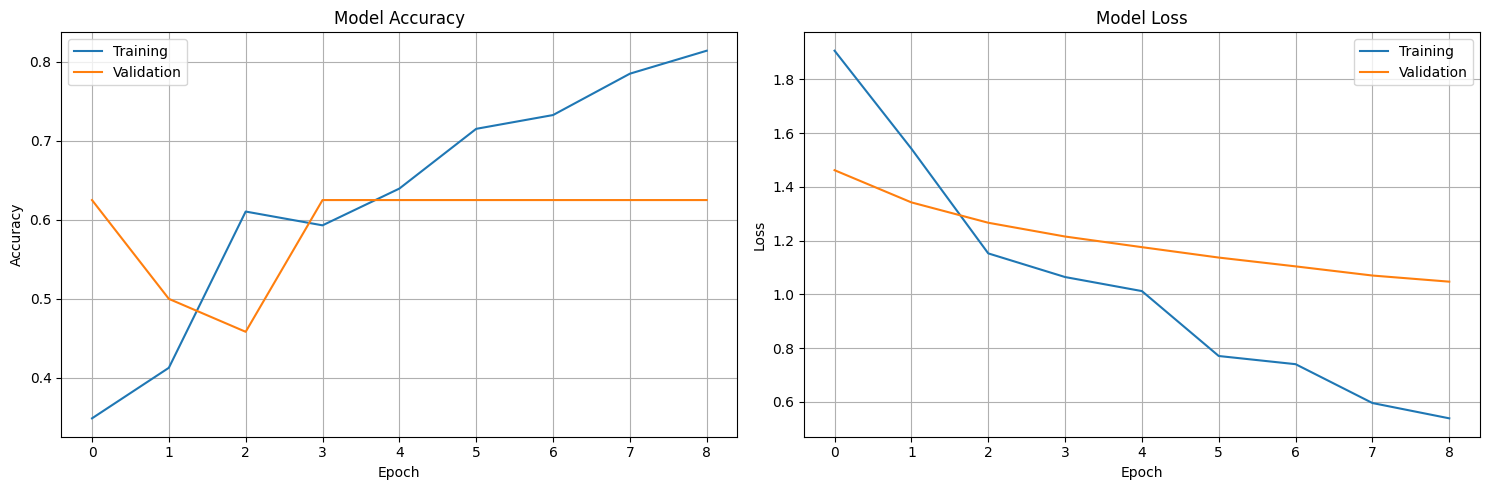


=== Final Evaluation ===

Test data: 36 samples
Test distribution: {1: 9, 2: 18, 3: 9}
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 750ms/step

=== Test Results ===
Test Accuracy: 0.4167

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
  Inner Race       0.56      1.00      0.72         9
  Outer Race       1.00      0.33      0.50        18
        Ball       0.00      0.00      0.00         9

    accuracy                           0.42        36
   macro avg       0.39      0.33      0.30        36
weighted avg       0.64      0.42      0.43        36



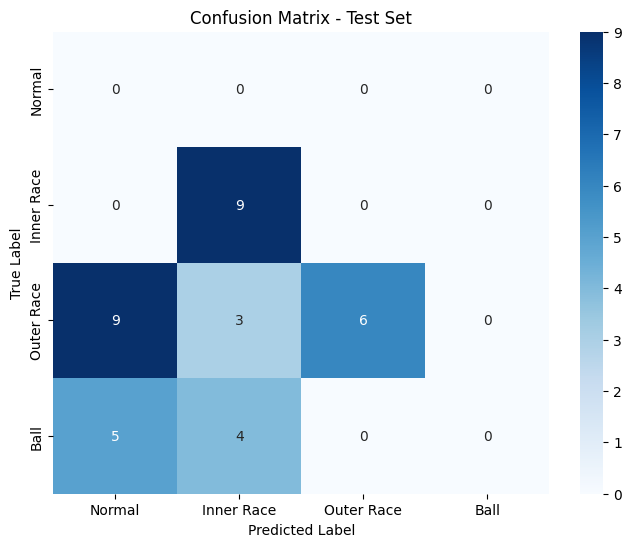


=== Summary ===
This evaluation uses file-based splitting - much more realistic!
Final Test Accuracy: 0.4167
This represents performance on completely unseen bearings.


In [3]:
# Realistic Bearing Health Classification with Proper Evaluation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from scipy.signal import spectrogram, stft, welch
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'sampling_rate': 12000,
    'window_sec': 5,
    'spectrogram_shape': (128, 128),  # Back to reasonable size
    'epochs': 30,
    'batch_size': 32,
    'learning_rate': 0.001,
    'data_path': "/kaggle/input/bearing-data",
    'test_split': 0.2,  # Use file-based splitting
    'validation_split': 0.15
}

class RealisticBearingProcessor:
    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
        self.file_info = []  # Track which segments come from which files
    
    def classify_file(self, filename):
        """Enhanced file classification"""
        filename_upper = filename.upper()
        if "IR" in filename_upper:
            return 1, "Inner_Race"
        elif "B0" in filename_upper or "BALL" in filename_upper:
            return 3, "Ball"
        elif "OR" in filename_upper:
            return 2, "Outer_Race"
        elif "NORMAL" in filename_upper or filename_upper.endswith('.MAT'):
            return 0, "Normal"
        else:
            return -1, "Unknown"
    
    def extract_features(self, signal, fs):
        """Extract comprehensive features"""
        # Time-domain features
        time_features = np.array([
            np.mean(signal),
            np.std(signal),
            np.var(signal),
            skew(signal),
            kurtosis(signal),
            np.max(signal),
            np.min(signal),
            np.sqrt(np.mean(signal**2)),  # RMS
            np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2)),  # Crest factor
            np.sqrt(np.mean(signal**2)) / np.mean(np.abs(signal))  # Shape factor
        ])
        
        # Frequency-domain features
        freqs, psd = welch(signal, fs, nperseg=1024)
        freq_features = np.array([
            np.sum(psd),  # Total power
            np.argmax(psd),  # Dominant frequency
            np.sum(psd * freqs) / np.sum(psd),  # Spectral centroid
            np.sqrt(np.sum(((freqs - np.sum(psd * freqs) / np.sum(psd)) ** 2) * psd) / np.sum(psd))  # Spectral spread
        ])
        
        return np.concatenate([time_features, freq_features])
    
    def segment_signal(self, signal, fs, window_sec, overlap=0.5):
        """Segment signal with overlap"""
        win_len = int(fs * window_sec)
        step = int(win_len * (1 - overlap))
        segments = []
        
        for start in range(0, len(signal) - win_len + 1, step):
            segments.append(signal[start:start + win_len])
        
        return segments
    
    def create_spectrogram(self, segment, fs, out_shape):
        """Create normalized spectrogram"""
        f, t, Sxx = spectrogram(segment, fs, nperseg=256, noverlap=128)
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Resize to target shape
        from scipy import ndimage
        if Sxx_db.shape != out_shape:
            Sxx_resized = ndimage.zoom(Sxx_db, 
                                      (out_shape[0]/Sxx_db.shape[0], 
                                       out_shape[1]/Sxx_db.shape[1]))
        else:
            Sxx_resized = Sxx_db
        
        # Normalize
        Sxx_norm = (Sxx_resized - np.mean(Sxx_resized)) / (np.std(Sxx_resized) + 1e-8)
        
        return Sxx_norm
    
    def process_data_file_aware(self):
        """Process data while tracking file origins for proper splitting"""
        all_data = []
        mat_files = glob.glob(os.path.join(self.config['data_path'], "*.mat"))
        
        print(f"Found {len(mat_files)} files to process")
        
        for filepath in tqdm(mat_files, desc="Processing files"):
            try:
                fname = os.path.basename(filepath)
                label_num, label_name = self.classify_file(fname)
                if label_num == -1:
                    continue
                
                # Load data
                data = loadmat(filepath)
                key = [k for k in data.keys() if "DE_time" in k or "de_time" in k.lower()][0]
                signal = data[key].ravel()
                
                # Extract file-level info (for potential use)
                file_id = fname.replace('.mat', '')
                
                # Segment signal
                segments = self.segment_signal(
                    signal, 
                    self.config['sampling_rate'], 
                    self.config['window_sec']
                )
                
                file_segments = []
                for i, segment in enumerate(segments):
                    # Create spectrogram
                    spec = self.create_spectrogram(
                        segment, 
                        self.config['sampling_rate'], 
                        self.config['spectrogram_shape']
                    )
                    
                    # Extract features
                    features = self.extract_features(segment, self.config['sampling_rate'])
                    
                    file_segments.append({
                        'spectrogram': spec,
                        'features': features,
                        'label': label_num,
                        'label_name': label_name,
                        'file_id': file_id,
                        'segment_id': i,
                        'filename': fname
                    })
                
                all_data.extend(file_segments)
                
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
        
        return all_data
    
    def split_by_files(self, all_data):
        """Split data ensuring no file appears in multiple sets"""
        # Get unique files per class
        files_by_class = {}
        for item in all_data:
            label = item['label']
            file_id = item['file_id']
            if label not in files_by_class:
                files_by_class[label] = set()
            files_by_class[label].add(file_id)
        
        print("\nFiles per class:")
        for label, files in files_by_class.items():
            label_name = all_data[0]['label_name'] if all_data[0]['label'] == label else str(label)
            print(f"Class {label}: {len(files)} files")
        
        # Split files for each class
        train_files, val_files, test_files = set(), set(), set()
        
        for label, files in files_by_class.items():
            files_list = list(files)
            np.random.shuffle(files_list)
            
            n_files = len(files_list)
            n_test = max(1, int(n_files * self.config['test_split']))
            n_val = max(1, int(n_files * self.config['validation_split']))
            n_train = n_files - n_test - n_val
            
            if n_train < 1:  # Ensure at least one file for training
                n_train = 1
                n_val = max(0, n_files - n_train - n_test)
            
            train_files.update(files_list[:n_train])
            val_files.update(files_list[n_train:n_train + n_val])
            test_files.update(files_list[n_train + n_val:])
        
        # Create datasets
        train_data = [item for item in all_data if item['file_id'] in train_files]
        val_data = [item for item in all_data if item['file_id'] in val_files]
        test_data = [item for item in all_data if item['file_id'] in test_files]
        
        return train_data, val_data, test_data
    
    def data_to_arrays(self, data_list):
        """Convert data list to numpy arrays"""
        if not data_list:
            return np.array([]), np.array([]), np.array([])
            
        spectrograms = np.array([item['spectrogram'] for item in data_list])
        features = np.array([item['features'] for item in data_list])
        labels = np.array([item['label'] for item in data_list])
        
        # Add channel dimension for spectrograms
        if len(spectrograms.shape) == 3:
            spectrograms = spectrograms[..., np.newaxis]
        
        return spectrograms, features, labels

class ImprovedBearingClassifier:
    def __init__(self, config):
        self.config = config
        self.model = None
        self.history = None
    
    def create_efficient_model(self, spec_shape, feat_shape, num_classes=4):
        """Create an efficient hybrid model"""
        
        # Spectrogram branch - Efficient CNN
        spec_input = layers.Input(shape=spec_shape, name='spectrogram')
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(spec_input)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        spec_features = layers.Dense(64, activation='relu')(x)
        
        # Feature branch
        feat_input = layers.Input(shape=(feat_shape,), name='features')
        y = layers.Dense(32, activation='relu')(feat_input)
        y = layers.BatchNormalization()(y)
        y = layers.Dropout(0.3)(y)
        feat_features = layers.Dense(32, activation='relu')(y)
        
        # Combine
        combined = layers.concatenate([spec_features, feat_features])
        combined = layers.Dense(64, activation='relu')(combined)
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(0.4)(combined)
        
        output = layers.Dense(num_classes, activation='softmax')(combined)
        
        model = Model(inputs=[spec_input, feat_input], outputs=output)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def create_callbacks(self):
        """Create training callbacks"""
        return [
            callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=1e-6,
                verbose=1
            )
        ]
    
    def train_model(self, train_data, val_data):
        """Train the model with proper validation"""
        
        # Convert to arrays
        X_spec_train, X_feat_train, y_train = train_data
        X_spec_val, X_feat_val, y_val = val_data
        
        print(f"Training data: {len(y_train)} samples")
        print(f"Validation data: {len(y_val)} samples")
        print(f"Training distribution: {pd.Series(y_train).value_counts().sort_index().to_dict()}")
        print(f"Validation distribution: {pd.Series(y_val).value_counts().sort_index().to_dict()}")
        
        # Create model
        self.model = self.create_efficient_model(
            X_spec_train.shape[1:],
            X_feat_train.shape[1]
        )
        
        print(f"\nModel Summary:")
        self.model.summary()
        
        # Train
        self.history = self.model.fit(
            [X_spec_train, X_feat_train], y_train,
            validation_data=([X_spec_val, X_feat_val], y_val),
            epochs=self.config['epochs'],
            batch_size=self.config['batch_size'],
            callbacks=self.create_callbacks(),
            verbose=1
        )
        
        return self.history
    
    def evaluate_model(self, test_data):
        """Comprehensive model evaluation"""
        X_spec_test, X_feat_test, y_test = test_data
        
        if len(y_test) == 0:
            print("No test data available!")
            return None
        
        print(f"\nTest data: {len(y_test)} samples")
        print(f"Test distribution: {pd.Series(y_test).value_counts().sort_index().to_dict()}")
        
        # Predictions
        y_pred_proba = self.model.predict([X_spec_test, X_feat_test])
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\n=== Test Results ===")
        print(f"Test Accuracy: {accuracy:.4f}")
        
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred, 
                                  target_names=['Normal', 'Inner Race', 'Outer Race', 'Ball']))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Inner Race', 'Outer Race', 'Ball'],
                    yticklabels=['Normal', 'Inner Race', 'Outer Race', 'Ball'])
        plt.title('Confusion Matrix - Test Set')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return accuracy, y_pred, y_pred_proba
    
    def plot_training_history(self):
        """Plot training curves"""
        if self.history is None:
            print("No training history available!")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy
        ax1.plot(self.history.history['accuracy'], label='Training')
        ax1.plot(self.history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Loss
        ax2.plot(self.history.history['loss'], label='Training')
        ax2.plot(self.history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

def main():
    """Main execution with realistic evaluation"""
    
    print("=== Realistic Bearing Health Classification ===")
    print("Using file-based train/val/test split to prevent data leakage\n")
    
    # Initialize
    processor = RealisticBearingProcessor(CONFIG)
    classifier = ImprovedBearingClassifier(CONFIG)
    
    # Process data
    print("Processing bearing data...")
    all_data = processor.process_data_file_aware()
    
    if not all_data:
        print("No data processed! Check your data path.")
        return
    
    print(f"Total segments processed: {len(all_data)}")
    
    # Split by files (realistic approach)
    print("\nSplitting data by files (no data leakage)...")
    train_data, val_data, test_data = processor.split_by_files(all_data)
    
    print(f"Train files: {len(set(item['file_id'] for item in train_data))}")
    print(f"Val files: {len(set(item['file_id'] for item in val_data))}")
    print(f"Test files: {len(set(item['file_id'] for item in test_data))}")
    
    # Convert to arrays
    train_arrays = processor.data_to_arrays(train_data)
    val_arrays = processor.data_to_arrays(val_data)
    test_arrays = processor.data_to_arrays(test_data)
    
    # Normalize features
    processor.scaler.fit(train_arrays[1])
    train_arrays = (train_arrays[0], processor.scaler.transform(train_arrays[1]), train_arrays[2])
    val_arrays = (val_arrays[0], processor.scaler.transform(val_arrays[1]), val_arrays[2])
    test_arrays = (test_arrays[0], processor.scaler.transform(test_arrays[1]), test_arrays[2])
    
    # Train model
    print("\n=== Training Model ===")
    history = classifier.train_model(train_arrays, val_arrays)
    
    # Plot training history
    classifier.plot_training_history()
    
    # Evaluate on test set
    print("\n=== Final Evaluation ===")
    test_accuracy, y_pred, y_pred_proba = classifier.evaluate_model(test_arrays)
    
    print(f"\n=== Summary ===")
    print(f"This evaluation uses file-based splitting - much more realistic!")
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print("This represents performance on completely unseen bearings.")
    
    return classifier, test_accuracy

# Run the realistic evaluation
if __name__ == "__main__":
    classifier, test_accuracy = main()